## Linear regression: Ordinary least squares

In this notebook we will go over the concept of ordinary least squares estimation for linear regression.  For a deeper dive into regression analysis, I would recommend ["The Truth about Linear Regression" by Cosma Shalizi](http://www.stat.cmu.edu/~cshalizi/TALR/).

In linear regression, we want to find the line:

$$
y = m*x + b
$$

that best relates two variables $x$ (the independent variable, or *predictor*) and $y$ (the dependent variable, or *outcome*).  We define "best" as the line that miminizes the squared error loss:

$$
L(y, \hat{y}) = \sum_{i=1}^N{(y_i - \hat{y})^2}
$$

where $\hat{y_i} = mx_i + b$.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy.stats


Let's first look at a simple example, with two simulated variables that are linearly related.

In [2]:
rng = np.random.RandomState(1)
npts = 20
noise_sd = 1
m = 0.5
b = 3
X = rng.randn(npts, 1)
y = X.dot(m) + b + rng.randn(npts, 1)*noise_sd


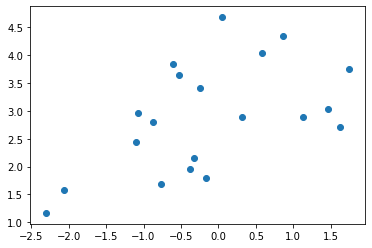

In [3]:
plt.scatter(X, y)

In [4]:
np.corrcoef(X[:, 0], y[:, 0])[0, 1]

0.5351419257742921

## Estimating the regression solution using ordinary least squares

One way to understand the estimation of the best fitting line is through the relationship between the regression slope and the correlation coefficient.

Remember the formula for the Pearson correlation:

$$
r = \frac{covariance_{x,y}}{s_x * s_y} = \frac{\sum_{i=1}^N{(x_i - \bar{x})(y_i - \bar{y})}}{(N-1)*s_x*s_y}
$$

where $s_x$ and $s_y$ are the standard deviations for the x and y variables. The estimate of the regression slope for a single independent variable is very similar:

$$
\hat{m} = \frac{covariance_{x,y}}{s^2_x}
$$

The only difference is that the correlation scales by the product of $s_x$ and $s_y$, whereas the regression slope scales only by the variance of the $x$ variable (i.e. $s^2_x$).  The relation between them is:

$$
\hat{m} = r * \frac{s_y}{s_x}
$$



Let's plot that line against our data:

(0.46289093635976236, 2.9492196505412007)

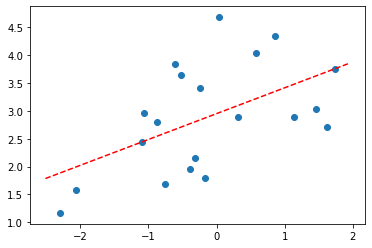

In [5]:
plt.scatter(X, y)

def abline(slope, intercept):
    """
    Plot a line from slope and intercept
    from: https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib
    
    slope: float, slope of line
    intercept: float, intercept of line
    """
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, 'r--')
    
# use ddof=1 argument for std, since we want the sample std
# rather than the population std (which is the default for np.std)
std_x = np.std(X, ddof=1)
std_y = np.std(y, ddof=1)
m_hat = np.corrcoef(X.T, y.T)[0,1] * (std_y/std_x)

# compute the intercept plugging in the mean values of X and Y
intercept_hat = np.mean(y) - m_hat*np.mean(X)

abline(m_hat, intercept_hat)
m_hat, intercept_hat

## Solving OLS using linear algebra


In general, we would use linear algebra to estimate the OLS solution, because it is more flexible. Framed as a linear algebra problem:

$$
\textbf{Y} = \textbf{X} \cdot \textbf{b}
$$

where:

- $\textbf{X}$ is the $N_{samples} X N_{features}$ *design matrix* containing the predictors (known)
- $\textbf{Y}$ is the $N_{samples} X N_{targets}$ matrix of outcomes to be predicted (known)
- $\textbf{b}$ is the $N_{features} X N_{targets}$ matrix of *regression parameters* (unknown)

In the case of simple linear regression (with a single x and single y variable), $N_{features} = 1$, $N_{targets} = 1$, and $N_{samples}$ is the number of data points.  

Using this linear algebra approach is is possible to have multiple Y variables (each of which gets its own set of parameter estimates), but we will primarily work with analyses where there is only a single target variable, as in the case of simple regression.

The outcomes $\textbf{Y}$ and predictors $\textbf{X}$ are known, and we need to estimate the values of $\textbf{b}$ that result in the minimum squared error loss.

Conceptually, one might imagine estimating $\textbf{b}$ by solving for it algebraically:

$$
\hat{\textbf{b}} = \frac{\textbf{Y}}{\textbf{X}}
$$

However, since X is a matrix, we can't simply divide by it. However, another way to think about this is that we can multiply $\textbf{Y}$ by the matrix inverse of $\textbf{X}$:

$$
\hat{\textbf{b}} = \textbf{X}^{-1} \cdot \textbf{Y}
$$

The problem here is that so far we only know how to compute the inverse of a square matrix, but $\textbf{X}$ is never going to be square (for reasons we will see later); it must always have more rows than columns.  In order to come up with $\textbf{X}^{-1}$, we need to use what is called the Moore-Penrose pseudoinverse, denoted $\textbf{X}^{+}$:

$$
\textbf{X}^{+} = (X^T \cdot X)^{-1} \cdot X^T
$$

for the particular case where $\textbf{X}$ has linearly independent columns and more rows than columns.  This produces a *left pseudoinverse*, meaning that if we want to multiply another vector by it, the pseudoinverse must be on the left.  We can now use this to generate the solution to our parameter estimation problem:

$$
\hat{\textbf{b}} = (X^T \cdot X)^{-1} \cdot X^T \cdot \textbf{Y}
$$

Because $(X^T \cdot X)^{-1}$ is the covariance matrix of X, and $ X^T \cdot \textbf{Y}$ is the covariance between $\textbf{X}$ and $\textbf{y}$, we can view this as a multivariate generalization of the estimation formula above:

$$
\hat{\textbf{b}} = \frac{cov(\textbf{X}, \textbf{Y})}{var(\textbf{X})}
$$



To estimate this, we need to allow the model to also estimate an intercept term.  This is basically a constant offset for all data points, so we can model this by adding a columns of ones to X. It is common in some fields to display the design matrix as an image, where the intensity relates to the magnitude of the values:

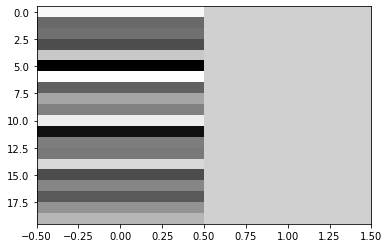

In [6]:
# add an intercept term to X
X_int = np.hstack((X, np.ones((X.shape[0], 1))))

# display design matrix as image
plt.imshow(X_int, cmap='gray', aspect='auto')


Now let's estimate the parameters using the pseudoinverse.  We can conceptually separate this out into a matrix that *projects* the data into the space of the design matrix; we will call this $H$, since it is often referred to as the *hat matrix* because it puts the "hat" onto beta:

In [7]:
# create hat matrix
H = np.linalg.inv(X_int.T.dot(X_int)).dot(X_int.T)

# estimate the parameters
b_hat = H.dot(y)

b_hat

array([[0.46289094],
       [2.94921965]])

We can also see the same result using the sklearn `LinearRegression` object.  This object by default automatically fits an intercept term, so we should turn that off since the intercept is already in our design matrix.

In [8]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=False)
lr.fit(X_int, y)
lr.coef_

array([[0.46289094, 2.94921965]])

## Geometric view

We can also view least squares estimation in geometric terms.  If we view our data as a vector in an N-dimensional space (where each data point in the vector defines a different dimension), then we can view the job of linear regression as projecting that N-dimensional space into a new space that has the same number of dimensions as there are predictors in the model (i.e. the number of columns in the design matrix).

Let's first create a simple dataset, with three observations:


In [43]:
y = np.array([[3, 2, 2]]).T  # data to plot
y

array([[3],
       [2],
       [2]])

Now let's plot those data in a three-dimensional space, where each data point is treated as a dimension.

Text(0.5, 0, 'X1')

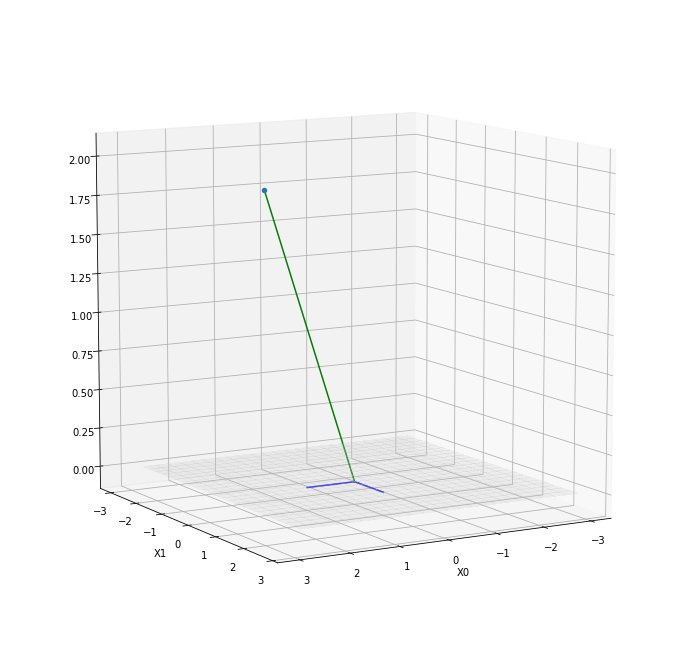

In [44]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')  # to work in 3d

# Make data for grid
Xgrid, Ygrid = np.meshgrid(np.arange(-3, 3, 0.25), np.arange(-3, 3, 0.25))
Zgrid = np.zeros(Xgrid.shape)

# Plot the surface.
ax.plot_surface(Xgrid, Ygrid, Zgrid, color='white',
                       linewidth=0, antialiased=False, alpha=0.2)

# set up variables for plotting
x = np.array([[1, 0, 0], [0, 1,0]]) # basis vectors

# plot basis vectors
for i in range(x.shape[0]):
    ax.plot3D([0, x[i, 0]], [0,x[i, 1]], [0, x[i, 2]], 'blue', )

# plot data vector
ax.plot3D([0, y[0, 0]], [0, y[1, 0]], [0, y[2, 0]], 'green',)
ax.scatter3D(y[0,0], y[1, 0], y[2, 0], cmap='Greens');

elev = 10
azim = 60
ax.view_init(elev, azim)  # set viewpoint
plt.xlabel('X0')
plt.ylabel('X1')

The idea behind least squares estimation is to project the $N_{samples}$ dimensional data into an $N_{features}$ dimensional space. In this example we will project the data into a two-dimensional space, represented as the plane containing the blue lines in the figure above.  To do this, we need to create a design matrix to represent the projection from the full space of the data into the restricted space of the design.

To do this, we create a design matrix X with two columns; the two columns should be linearly independent, and each column should have equal norm (which we will set to one).

array([[0.70710678, 0.        ],
       [0.        , 0.70710678],
       [0.70710678, 0.70710678]])

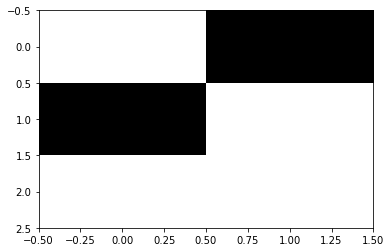

In [45]:
X = np.array([[1, 0], [0, 1], [1,1]])
# normalize
X = X / np.linalg.norm(X[:,0])
plt.imshow(X, cmap='gray', aspect='auto')
X

Now we use our formula from above to estimate $\hat{b}$ from the data:

In [46]:
bhat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print(bhat)

[[2.82842712]
 [1.41421356]]


Now let's plot the estimated parameters in our space (the dotted black line):

Text(0.5, 0, 'X1')

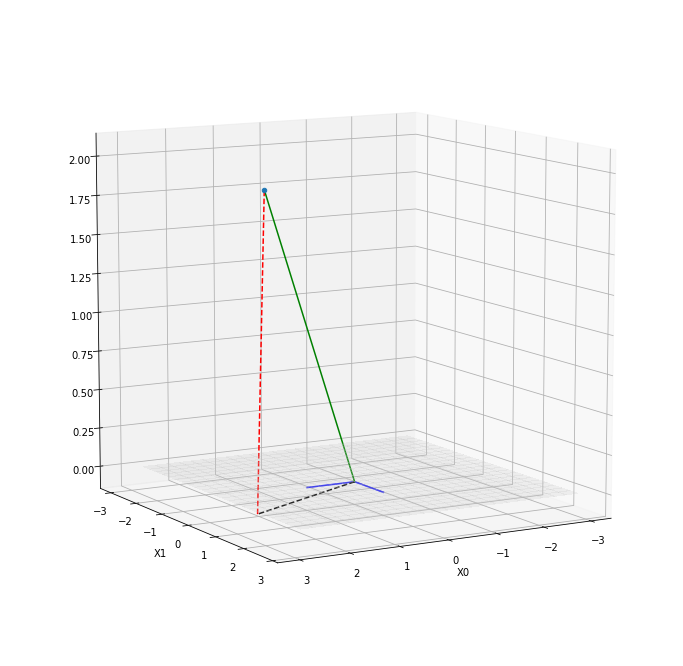

In [101]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')               # to work in 3d

# Plot the surface.
ax.plot_surface(Xgrid, Ygrid, Zgrid, color='white',
                       linewidth=0, antialiased=False, alpha=0.2)

# set up variables
y = np.array([[3, 2, 2]]).T
x = np.array([[1, 0, 0], [0, 1,0]])


# plot basis vectors
for i in range(x.shape[0]):
    ax.plot3D([0, x[i, 0]], [0,x[i, 1]], [0, x[i, 2]], 'blue', )

# plot data vector
ax.plot3D([0, y[0, 0]], [0, y[1, 0]], [0, y[2, 0]], 'green',)
ax.scatter3D(y[0,0], y[1, 0], y[2, 0], cmap='Greens');

# plot projection vector
ax.plot3D([0, bhat[0]], [0, bhat[1]], [0, 0], 'k--')

# plot error vector
ax.plot3D([bhat[0], y[0, 0]], [bhat[1], y[1, 0]], [0, y[2, 0]], 'r--')

ax.view_init(elev, azim) # set viewpoint
plt.xlabel('X0')
plt.ylabel('X1')


We now see that the original data vector (green line) has been decomposed into the projection into the column space of the design (black line), and the residual error (red line).  Let's confirm that the combination of the norms of these vectors (by the Pythagorean theorem) is the same as the norm of the original data.


In [57]:
norm_y = np.linalg.norm(y)
norm_y

4.123105625617661

In [58]:
norm_yhat = np.linalg.norm(X.dot(bhat))
norm_yhat

3.741657386773942

In [59]:
resid = y - X.dot(bhat)
norm_resid = np.linalg.norm(resid)
norm_resid

1.7320508075688774

In [51]:
assert np.allclose(norm_y, np.sqrt(norm_yhat**2 + norm_resid**2))

The geometric view also provides a way to understand how well the model fits the data.  Let's fit the model using the `OLS` function from the statsmodels package, which provides additional fit statistics:

In [77]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.824
Model:                            OLS   Adj. R-squared (uncentered):              0.471
Method:                 Least Squares   F-statistic:                              2.333
Date:                Tue, 14 Apr 2020   Prob (F-statistic):                       0.420
Time:                        07:53:54   Log-Likelihood:                         -4.2568
No. Observations:                   3   AIC:                                      12.51
Df Residuals:                       1   BIC:                                      10.71
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/Users/poldrack/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  "samples were given." % int(n), ValueWarning)


You see that the R-squared for the model is 0.824.  Remember that the R-squared is computed as:

$$
R^2 = \frac{SS_{model}}{SS_{total}} 
$$

We can compute these sums of squares by simply squaring the norm of the two relevant vectors:

$$
SS_{total} = \|Y\|^2
$$


$$
SS_{model} = \|\hat{Y}\|^2
$$

and thus:

$$
R^2 = \frac{\|\hat{Y}\|^2}{\|Y\|^2}
$$

which we can confirm here:


In [41]:
(norm_yhat**2)/norm_y**2

0.8235294117647063

One thing to note: From this view, as from the matrix algebra view, it doesn't really matter how many predictors there are in the design (that is, how many dimensions are are projecting into), as long as it's less than the number of dimensions in the data.  Thus, we don't really need to worry about the distinction between *simple* and *multiple* regression from this context.

We also haven't said anything about the nature of the design matrix, such as the relations between the regressors.  For now we will simply note that the design matrix must be full rank; that is, no regressor is an exact linear combination of other regressors.

## Fitting OLS to data

Now let's use the SRO dataset to assess the degree to which household income is predicted by fluid intelligence (as measured using the Raven's progressive matrices) and delay discounting (as measured using the Kirby intertemporal choice task).

In [81]:
def get_SRO_data(SRO_datadir = './data/SRO', vars = None):
    """
    load Eisenberg et al. dataset
    - by default, load the summary variables from meaningful_variables.csv 
    and the demographic/health data from demographics_health.csv
    
    vars: specific variables to return (if None, return all)
    """

    mvars = pd.read_csv(os.path.join(SRO_datadir, 'meaningful_variables.csv'), index_col=0)
    dvars = pd.read_csv(os.path.join(SRO_datadir, 'demographic_health.csv'), index_col=0)
    
    alldata = mvars.join(dvars)
    if vars is not None:
        assert isinstance(vars, list)
        alldata = alldata[vars]
    return(alldata)

SROdata = get_SRO_data(vars=['kirby.percent_patient', 'ravens.score', 'HouseholdIncome'])
# filter out zero income and unreasonably small values
SROdata = SROdata.query('HouseholdIncome>500')
SROdata.shape

(520, 3)

First let's fit a linear regression model to the full dataset, using the statstmodels `OLS()` function:

In [133]:
y = SROdata['HouseholdIncome'].copy()
X = SROdata[['kirby.percent_patient', 'ravens.score']].copy()
X['intercept'] = 1
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        HouseholdIncome   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     10.73
Date:                Tue, 14 Apr 2020   Prob (F-statistic):           2.72e-05
Time:                        08:47:35   Log-Likelihood:                -6107.3
No. Observations:                 520   AIC:                         1.222e+04
Df Residuals:                     517   BIC:                         1.223e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
kirby.percent_patient  2.039e+

This shows that both tasks are significantly associated with the outcome, though they account for a relatively small amount of variance (about 4%).  

## Regression diagnostics

It's always a good idea to make sure that our model is well specified and that the assumptions of our model are satisfied.  First, let's check whether the model is well specified, by plotting the residuals and squared residuals against the X variables and the fitted values:

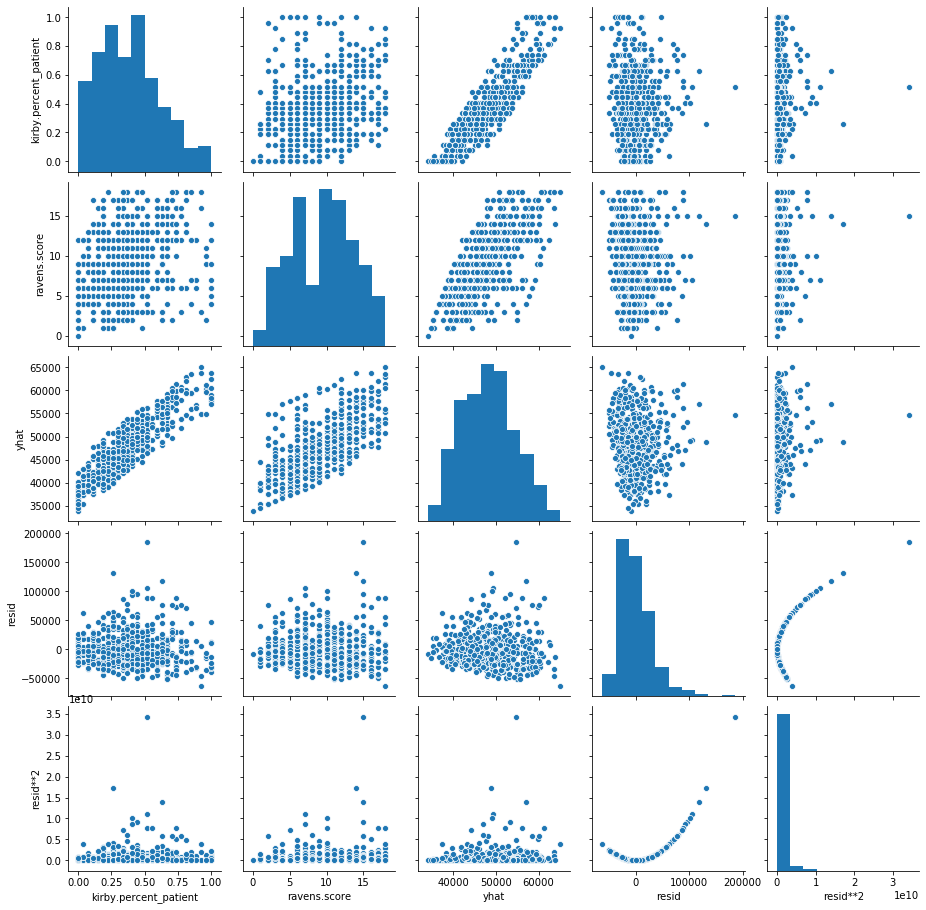

In [134]:
ols_df = X.copy()
del ols_df['intercept']
ols_df['yhat'] = results.fittedvalues
ols_df['resid'] = results.resid
ols_df['resid**2'] = results.resid**2

sns.pairplot(ols_df)

Comparing the residuals to the X variables and fitted values there is no clear structure, suggesting that the model is not badly specified.  If clear strucure is present in the residuals (e.g. bimodal distribution) then this suggests that the model is not well specified - that is, that there is some other variable that should be included in the model that will render the residuals normal.

The OLS procedure does not require any assumptions regarding the distribution of the errors, but the standard inference procedures for the regression parameters requires the assumption that errors are normally distributed with constant variance.  The Jarque-Bera test reported in the statsmodels output is highly significant, suggesting that there is a lack of normality in the residuals. However, these kinds of tests for normality are often discouraged because they may be overly sensitive.  We can also visualize normality of residuals using a Q-Q plot:

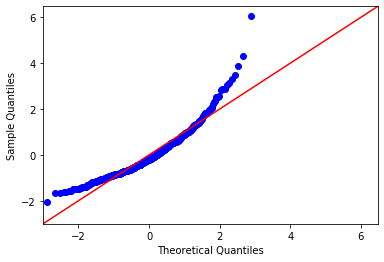

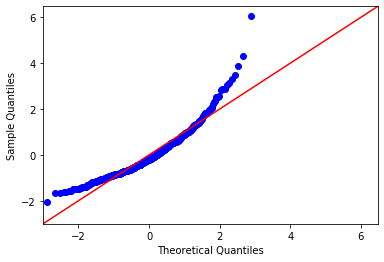

In [135]:
sm.qqplot(results.resid, scipy.stats.norm, fit=True, line='45')

There seems to be substantial non-normality in the residuals. One way to address this is by transforming the y values, which are heavily skewed.  There are various transforms that one can use for skewed data, such as the log or square root, but we will use the Box-Cox transformation procedure, which is an adaptive procedure that determine the optimal transform of the data:

In [136]:
y = scipy.stats.boxcox(SROdata['HouseholdIncome'].copy())[0]
X = SROdata[['kirby.percent_patient', 'ravens.score']].copy()
X['intercept'] = 1
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     7.878
Date:                Tue, 14 Apr 2020   Prob (F-statistic):           0.000426
Time:                        08:50:45   Log-Likelihood:                -2310.3
No. Observations:                 520   AIC:                             4627.
Df Residuals:                     517   BIC:                             4639.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
kirby.percent_patient    12.74

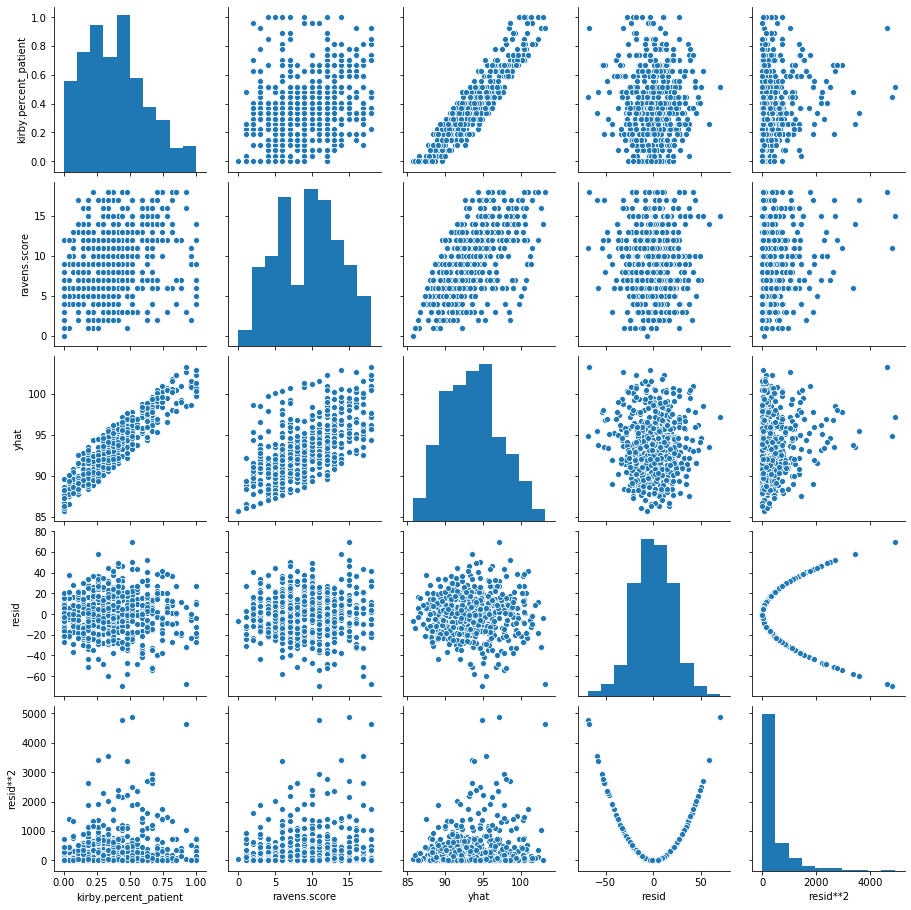

In [137]:
ols_df = X.copy()
del ols_df['intercept']
ols_df['yhat'] = results.fittedvalues
ols_df['resid'] = results.resid
ols_df['resid**2'] = results.resid**2

sns.pairplot(ols_df)

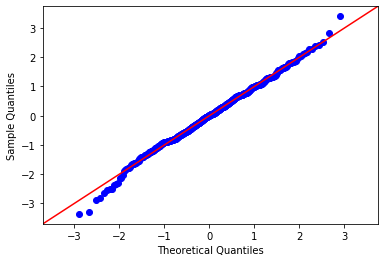

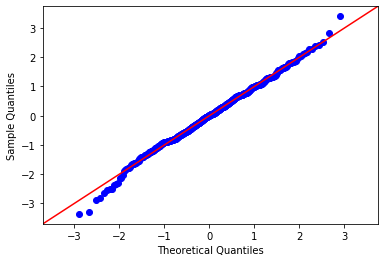

In [138]:
sm.qqplot(results.resid, scipy.stats.norm, fit=True, line='45')

The residuals now appear to be much better approximated by a normal distribution.  The main drawback of transformations is that the regression parameters are no longer intepretable in terms of units of the original Y variable.  We will see later how one can also use a linear model (known as a *generalized linear model*) that allows for error distributions other then the normal distribution.

## Collinearity in the design matrix

Collinearity between regressors in the design does not affect the overall fit of the model, but it does affect the variance of the parameter estimates.  This is best seen through simulation.  Let's generate two regressors and an outcome based on the common variance, varying the level of correlation between the regressors:



In [23]:
n_subjects = 100
corr = 0.5
noise_sd = 1

corrvals = np.arange(0,1, 0.1)

beta = [3, -1, 0]
nruns = 100

scores = pd.DataFrame({'corr': np.zeros(nruns*len(corrvals)),
                      'beta1': np.zeros(nruns*len(corrvals)),
                      'beta2': np.zeros(nruns*len(corrvals)),
                      'intercept': np.zeros(nruns*len(corrvals)),
                      'score': np.zeros(nruns*len(corrvals)),
                      'VIF_beta1': np.zeros(nruns*len(corrvals))})

lr = LinearRegression(fit_intercept=False)
rng = np.random.RandomState(1)

ctr=0
for i, corr in enumerate(corrvals):
    for j in range(nruns):
        X = rng.multivariate_normal(mean=[0, 0],
            cov=[[1, corr], [corr, 1]], size=n_subjects)
        X = sm.add_constant(X)
        
        # compute variance inflation factor - see below
        scores.loc[ctr, 'VIF_beta1'] = variance_inflation_factor(X, 1)
        
        y = X.dot(beta) + rng.randn(X.shape[0])*noise_sd
        lr.fit(X, y)
        
        scores.loc[ctr, 'score'] = lr.score(X, y)
        scores.loc[ctr, 'corr'] = corr
        scores.loc[ctr, 'beta1'] = lr.coef_[1]
        ctr += 1
        

Now let's look at the parameter estimates for beta 1 and see how they relate to the actual value, as a function of the correlation between regressors.
    

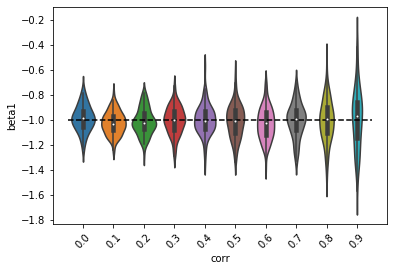

In [24]:
import seaborn as sns
vplot = sns.violinplot(x="corr", y="beta1",
               data=scores)
vplot.plot([-0.5, 9.5], [beta[1], beta[1]], 'k--')
locs, labels =plt.xticks()
_ = plt.xticks(locs,
               rotation=45, 
               labels = ['%.01f' % i for i in np.unique(scores['corr'])])

Here we see that the correlation in the design matrix did not cause any bias, but it did increase the variability of the parameter estimates. This follows a specific pattern, known as the *variance inflation factor*:

$$ VIF = \frac{1}{(1 - R^2)} $$

Let's plot the observed variance against the variance that we would expect by applying the VIF to the observed variance for the uncorrelated case:

Text(0, 0.5, 'Variance in parameter estimates')

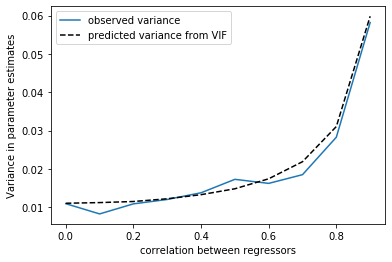

In [25]:
# summarize simulation runs by correlation values
beta1_summary = scores[['corr', 'beta1', 'VIF_beta1']].groupby('corr').describe()

# plot variance of parameter values
plt.plot(beta1_summary.index, beta1_summary.loc[:, ('beta1',   'std')]**2)

# get prediction from VIF
pred_std = (beta1_summary.loc[0, ('beta1',   'std')]**2) * beta1_summary.loc[:, ('VIF_beta1',   'mean')] 

# plot predicted
plt.plot(beta1_summary.index, pred_std, 'k--')
plt.legend(['observed variance', 'predicted variance from VIF'])
plt.xlabel('correlation between regressors')
plt.ylabel('Variance in parameter estimates')

Here we see that the observed variance closely follows that predicted by the VIF.  

Importantly, the presence of correlations within the design matrix does *not* change the overall fit of the model, which we can see by plotting the distributions of fit scores ($R^2$) for each level of correlation:

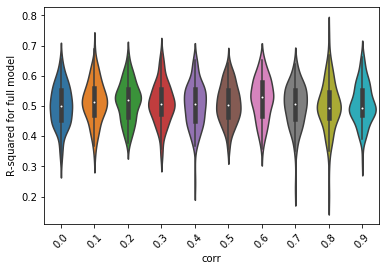

In [26]:
sns.violinplot(x="corr", y="score",
               data=scores)
locs, labels =plt.xticks()
plt.ylabel('R-squared for full model')
_ = plt.xticks(locs,
               rotation=45, 
               labels = ['%.01f' % i for i in np.unique(scores['corr'])])

We will see in the session on regularization how one can improve performance 

## Effects of orthogonalization

In the analysis of neuroimaging data using general linear models (GLMs), it is often common to find that regressors of interest
are correlated with one another.  While this inflates the variance of the estimated parameters, the foregoing showed us how OLS ensures that the 
estimated parameters only reflect the unique variance associated with the particular regressor; any shared variance
between regressors, while accounted for in the total model variance, is not reflected in the individual parameter 
estimates.  In general, this is as it should be; when it is not possible to uniquely attribute variance to any
particular regressor, then it should be left out.   Later in the course we will encounter other ways to address this issue, in the context of regularized regression.

Unfortunately, there is a tendency within the fMRI literature to overthrow this feature of the GLM by "orthogonalizing"
variables that are correlated.  This, in effect, assigns the shared variance to one of the correlated variables based 
on the experimenter's decision.  While statistically valid, this raises serious conceptual concerns about the 
interpretation of the resulting parameter estimates.

The first point to make is that, contrary to claims often seen in fMRI papers, the presence of correlated regressors
does not require the use of orthogonalization; in fact, in our opinion there are very few cases in which it is appropriate
to use orthogonalization, and its use will most often result in problematic conclusions.  See [Mumford et al., 2015](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0126255) for a deeper discussion of this issue.

As an example of how the GLM deals with correlated regressors and how this is affected by orthogonalization,
we first generate some synthetic data to work with.



In [107]:
npts = 100
corr = 0.5
rng = np.random.RandomState(1)

X = rng.multivariate_normal([0, 0], 
                                  [[1, corr],[corr, 1]], npts)
X = X - np.mean(X, 0)  # center variables

params = [1, 2]
y_noise = 0.2
Y = X.dot(params) + y_noise*rng.randn(npts)

orth_df = pd.DataFrame({'Y': Y,
                       'X0': X[:,0],
                       'X1': X[:,1]})

Plot the relation between each X variable and Y

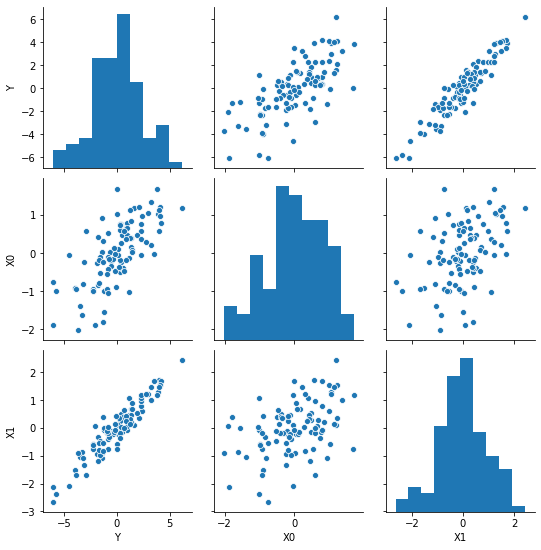

In [108]:
sns.pairplot(orth_df)

Now let's compute the parameters for the two columns in X using linear regression.  They should come out very close
to the values specified for params above.

In [29]:
# include rcond=None to suppress annoying warning
params_est =  np.linalg.lstsq(X,Y, rcond=None)[0]

print(params_est)

[1.01335978 1.97192289]


Now let's orthogonalize the second regressor (X1) with respect to the first (X0) and create a new orthogonalized design matrix X_orth. One way to do this is to fit a regression and then take the residuals; this is known as Gram-Schmidt orthogonalization.  We should see that the orthogonalized design matrix becomes uncorrelated.

In [30]:
x0_slope = np.linalg.lstsq(X[:, 0].reshape((npts, 1)), X[:, 1].reshape((npts, 1)), rcond=None)[0]

X_orth = X.copy()

X_orth[:, 1] = X[:, 1] - X[:, 0] * x0_slope

print('Correlation matrix for original design matrix')
print(np.corrcoef(X.T))

print('Correlation matrix for orthogonalized design matrix')
print(np.corrcoef(X_orth.T))


Correlation matrix for original design matrix
[[1.         0.43032844]
 [0.43032844 1.        ]]
Correlation matrix for orthogonalized design matrix
[[1.00000000e+00 2.56953573e-16]
 [2.56953573e-16 1.00000000e+00]]


Now let's look at the parameter estimates for the orthogonalized model:

In [31]:
params_est_orth =  np.linalg.lstsq(X_orth,Y, rcond=None)[0]

print(params_est_orth)

[1.97823776 1.97192289]


So what we see is that the parameter estimate for the orthogonalized regressor *did not change*!  Instead, the parameter estimate for the orthogonalized-against regressor changed, because all of the common variance is now being assigned to this regressor. Note that the interpretation of this effect is different than before: The effect for X0_orth is "the unique effect of X0 along with the common effect of X0 and X1".  One has to be very careful in using orthogonalization, and in general it is not a good idea ([Mumford et al., 2015](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0126255)).

## Crossvalidation with regression

To assess the quality of the regression model, we can use cross-validation to assess out-of-sample fit.  Doing crossvalidation in the context of regression is tricky, because many standard crossvalidation techniques will result in imbalanced distributions of the outcome variable across folds, leading to poor performance.  For this reason, it is suggested to either use a technique that explicitly balances the distribution of the Y variable across folds, or to use a ShuffleSplit method if the dataset is large enough to allow a large proportion of test examples.  Here we will use the `BalancedKFold` function (defined in 

In [32]:
from sklearn.metrics import r2_score
from balanced_kfold import BalancedKFold


# set up SRO data from before:
# we don't need intercept column since it's fit by sklearn
y = SROdata['HouseholdIncome'].copy().values
X = SROdata[['kirby.percent_patient', 'ravens.score']].copy().values

kf = BalancedKFold(4)

predicted = np.zeros((X.shape[0], 1))
lr = LinearRegression()

for train_index, test_index in kf.split(X, y, seed=1):
    # create separate train and test datasets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # train the model
    lr.fit(X_train, y_train)
    predicted[test_index, 0] = lr.predict(X_test)



In [33]:
observed_r2 = r2_score(y, predicted)
observed_r2

0.03296213702278117

This sounds like a fairly small number, but predicting even 3% of the variance in an important outcome could be scientifically useful; that is a scientific and practical question rather than a statistical question.

In order to assess the degree to which this value is greater than that expected by chance, we can use a randomization approach in which we repeatedly run this analysis, each time randomly shuffling the order of outcome variable. This breaks the relationship between X and y, essentially showing us the expected distribution under the null hypothesis of no relationship.  *NOTE*: This requires the assumption that rows in the dataset are exchangeable, which should be fulfilled when the individuals are random samples from a population. One would not want to use this for, e.g., timeseries data where the there are substantial correlations between subsequent rows.

In [34]:
# implement a function to run the CV once

def run_SRO_cv(X, y, score_fun=r2_score,
               seed = None, shuffle=False):
    kf = BalancedKFold(4)
    if shuffle:
        y = y.copy()
        np.random.shuffle(y)
    predicted = np.zeros((X.shape[0], 1))
    lr = LinearRegression()

    for train_index, test_index in kf.split(X, y, seed=seed):
        # create separate train and test datasets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # train the model
        lr.fit(X_train, y_train)
        predicted[test_index, 0] = lr.predict(X_test)

    return(r2_score(y, predicted))

run_SRO_cv(X, y, 1)

0.03495024233994204

Obtain the null distribution by repeatedly running this function with `shuffle=True`. Since we are looking at the tails, it's generally good to run a large number of randomizations, at least 2500.

In [35]:
nruns = 2500
r2_rand = np.zeros(nruns)

for i in range(nruns):
    
    r2_rand[i] = run_SRO_cv(X, y, 1, shuffle=True)

Find the proportion of randomization runs that have as large or larger $R^2$ as the observed data without shuffling:

In [36]:
pval = 1 - scipy.stats.percentileofscore(r2_rand, observed_r2)/100
pval

0.0

None of the randomization runs had an $R^2$ as large as or larger than our observed value, meaning that we can reject the null hypothesis of no predictive relationship.  We can see this by plotting the histogram of $R^2$ values from the randomization runs alongside the observed value:

Text(0, 0.5, 'Count')

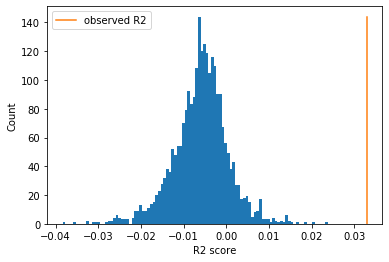

In [37]:
h = plt.hist(r2_rand, 100)
plt.plot([observed_r2, observed_r2], [0, max(h[0])])
plt.legend(['observed R2'])
plt.xlabel('R2 score')
plt.ylabel('Count')

This analysis shows that the observed degree of predictive accuracy is well above what would be expected by chance alone.